# Setup enviorment

In [1]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [2]:
""" Read Dataset:"""

embeddings = 'Embeddings/variational_autoencoder_224_1024.csv'
static = '../Tabular_data/dengue_tabular.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 3
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [3]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality, static=static) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe fo

list

### Train Test split

In [4]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 1051)
The test shape is: (33, 1051)
The train shape is: (130, 1051)
The test shape is: (33, 1051)
The train shape is: (130, 1051)
The test shape is: (33, 1051)
The train shape is: (130, 1051)
The test shape is: (33, 1051)
The train shape is: (130, 1051)
The test shape is: (33, 1051)
The train shape is: (130, 1051)
The test shape is: (33, 1051)
The train shape is: (130, 1051)
The test shape is: (33, 1051)
The train shape is: (130, 1051)
The test shape is: (33, 1051)
The train shape is: (130, 1051)
The test shape is: (33, 1051)
The train shape is: (130, 1051)
The test shape is: (33, 1051)


### Normalize features

In [5]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [6]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201546 -0.152315 -0.008257  0.229576 -0.459560 -0.115707 -0.250769   
      201547 -0.429644 -0.180829  0.196399  0.251703  0.151782  0.120646   
      201548 -0.161068  0.576082 -0.324825  0.105533  0.241237  0.022886   
      201549 -0.260170  0.167611 -0.298852  0.011480  0.048733  0.113631   
      201550  0.441330  0.225024  0.025560 -0.678361  0.065666 -0.795079   

                     6         7         8         9  ...  \
41001 201546 -0.473106 -0.372146 -0.407803  0.184894  ...   
      201547 -0.128355 -0.304024  0.658483 -0.437008  ...   
      201548  0.055301 -0.310014 -0.244395  0.053250  ...   
      201549 -0.398770 -0.094119  0.217093 -0.104882  ...   
      201550  0.085061 -0.637887  0.213285  0.176507  ...   

              Buildingstratification1(%)  Buildingstratification2(%)  \
41001 201546                    -0.38184                     0.90498   
      201547                    -0.38184                     0.90498   
      201548                    -0.38184                     0.90498   
      201549                    -0.38184                     0.90498   
      201550                    -0.38184                     0.90498   

              Buildingstratification3(%)  Buildingstratification4(%)  \
41001 201546                   -0.917415                   -0.851179   
      201547                   -0.917415                   -0.851179   
      201548                   -0.917415                   -0.851179   
      201549                   -0.917415                   -0.851179   
      201550                   -0.917415                   -0.851179   

              Buildingstratification5(%)  Buildingstratification6(%)  \
41001 201546                     -0.7492                   -0.981855   
      201547                     -0.7492                   -0.981855   
      201548                     -0.7492                   -0.981855   
      201549                     -0.7492                   -0.981855   
      201550                     -0.7492                   -0.981855   

              NumberofhospitalsperKm2  NumberofhousesperKm2  population  \
41001 201546                -0.990366               -0.9891   -0.924272   
      201547                -0.990366               -0.9891   -0.924272   
      201548                -0.990366               -0.9891   -0.924272   
      201549                -0.990366               -0.9891   -0.924272   
      201550                -0.990366               -0.9891   -0.924272   

                Labels  
41001 201546 -0.861740  
      201547 -0.854589  
      201548 -0.856973  
      201549 -0.856973  
      201550 -0.823600  

[5 rows x 1051 columns]

In [7]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2         3         4         5  \
41001 201820  0.377501  0.058192 -0.121884  0.142221 -0.422123 -0.338568   
      201821  0.425911  0.212401 -0.038819 -0.400261  0.254694 -0.448073   
      201822 -0.069995  0.237755  0.151022 -0.046802  0.012595 -0.410129   
      201823  0.308861  0.156666  0.139823  0.301422 -0.530209 -0.318304   
      201824 -0.443093  0.134781 -0.274972  0.309000 -0.442412 -0.329776   

                     6         7         8         9  ...  \
41001 201820 -0.301512  0.143935  0.010483  0.500248  ...   
      201821  0.297020 -0.398212  0.184892  0.256703  ...   
      201822 -0.120283  0.390381 -0.328007  0.219778  ...   
      201823  0.175030  0.086659  0.598123  0.222864  ...   
      201824 -0.570991 -0.178042  0.269263  0.467060  ...   

              Buildingstratification1(%)  Buildingstratification2(%)  \
41001 201820                    -0.38184                     0.90498   
      201821                    -0.38184                     0.90498   
      201822                    -0.38184                     0.90498   
      201823                    -0.38184                     0.90498   
      201824                    -0.38184                     0.90498   

              Buildingstratification3(%)  Buildingstratification4(%)  \
41001 201820                   -0.917415                   -0.851179   
      201821                   -0.917415                   -0.851179   
      201822                   -0.917415                   -0.851179   
      201823                   -0.917415                   -0.851179   
      201824                   -0.917415                   -0.851179   

              Buildingstratification5(%)  Buildingstratification6(%)  \
41001 201820                     -0.7492                   -0.981855   
      201821                     -0.7492                   -0.981855   
      201822                     -0.7492                   -0.981855   
      201823                     -0.7492                   -0.981855   
      201824                     -0.7492                   -0.981855   

              NumberofhospitalsperKm2  NumberofhousesperKm2  population  \
41001 201820                -0.990366               -0.9891   -0.924272   
      201821                -0.990366               -0.9891   -0.924272   
      201822                -0.990366               -0.9891   -0.924272   
      201823                -0.990366               -0.9891   -0.924272   
      201824                -0.990366               -0.9891   -0.924272   

                Labels  
41001 201820 -0.949940  
      201821 -0.961859  
      201822 -0.940405  
      201823 -0.961859  
      201824 -0.954708  

[5 rows x 1051 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [8]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(128, 3151)

### Merge train data

In [9]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [10]:
train.shape

(1280, 3151)

### Features and Labels Set

In [11]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1280, 3150)
The shape of the labels is (1280, 1)
Test:
The shape of the features is (310, 3150)
The shape of the labels is (310, 1)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

The initial shapes are:
The train shape is (1280, 3150)
The test shape is (310, 3150)
-----------------------
The Final shapes are:
The train shape is (1280, 3, 1050)
The test shape is (310, 3, 1050)


# 2. Model

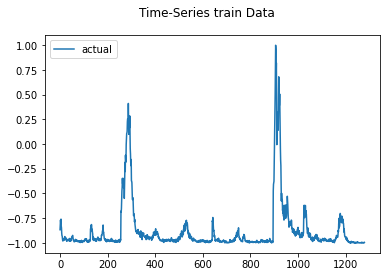

2023-03-08 15:52:49.703801: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-08 15:52:49.703853: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-08 15:52:49.703885: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-08 15:52:49.704273: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 15:52:52.791588: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 32.519
Test RMSE: 45.376
Test sMAPE: 113.799
Test R Squared: -1.075
{'mae': 32.51912773520716, 'rmse': 45.37616278637462, 'smape': 113.79857391713507, 'r2': -1.0753457924748937}


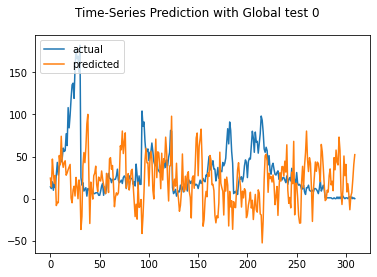

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 40.211
Test RMSE: 51.684
Test sMAPE: 105.191
Test R Squared: -1.692
{'mae': 40.21136105214396, 'rmse': 51.684447929596665, 'smape': 105.19109640733137, 'r2': -1.6924937129139233}


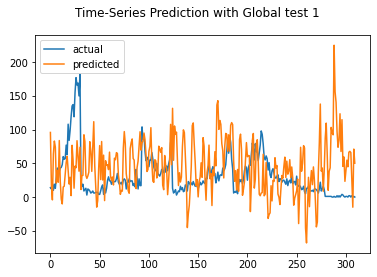

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 42.670
Test RMSE: 52.614
Test sMAPE: 133.482
Test R Squared: -1.790
{'mae': 42.67033445681295, 'rmse': 52.61378264250183, 'smape': 133.48198792821483, 'r2': -1.7901913442722006}


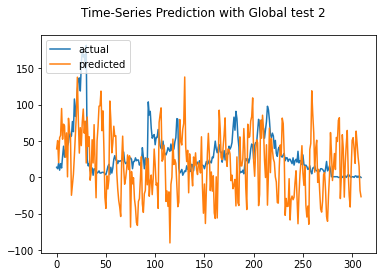

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 39.688
Test RMSE: 48.783
Test sMAPE: 114.203
Test R Squared: -1.399
{'mae': 39.688160626542185, 'rmse': 48.78269116691935, 'smape': 114.20337267566478, 'r2': -1.3986475830177647}


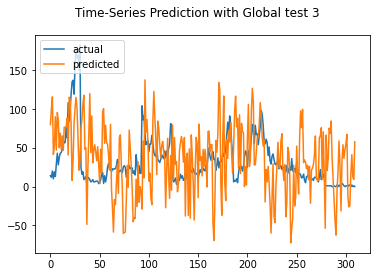

Test MAE: 34.316
Test RMSE: 40.814
Test sMAPE: 90.242
Test R Squared: -0.679
{'mae': 34.31550426790792, 'rmse': 40.81405629751427, 'smape': 90.2418807884024, 'r2': -0.6790145237839467}


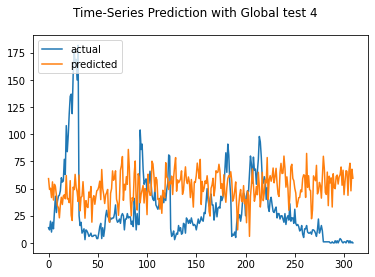

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 39.562
Test RMSE: 46.567
Test sMAPE: 99.889
Test R Squared: -1.186
{'mae': 39.56240102994826, 'rmse': 46.5671632708053, 'smape': 99.88900968563485, 'r2': -1.18571986899933}


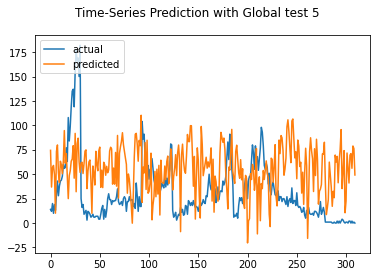

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 36.604
Test RMSE: 44.736
Test sMAPE: 92.766
Test R Squared: -1.017
{'mae': 36.603856504348016, 'rmse': 44.73575325163323, 'smape': 92.7662054856359, 'r2': -1.017179022499597}


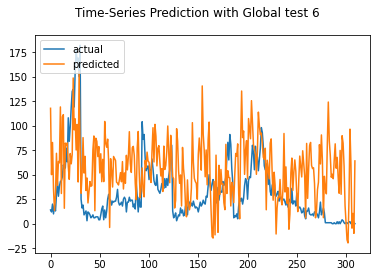

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 40.213
Test RMSE: 48.387
Test sMAPE: 115.245
Test R Squared: -1.360
{'mae': 40.21275769058735, 'rmse': 48.38721389161194, 'smape': 115.24540868618895, 'r2': -1.3599139488636935}


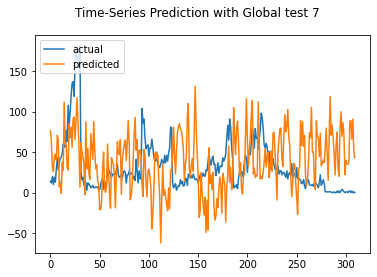

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 39.256
Test RMSE: 48.284
Test sMAPE: 95.111
Test R Squared: -1.350
{'mae': 39.256251710076484, 'rmse': 48.28429879787638, 'smape': 95.11121726692627, 'r2': -1.3498859904836609}


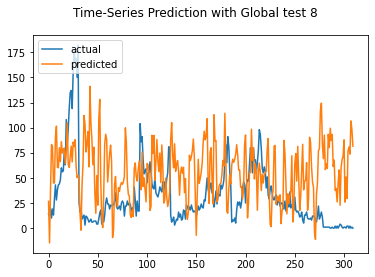

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 43.005
Test RMSE: 53.734
Test sMAPE: 109.474
Test R Squared: -1.910
{'mae': 43.00546203438313, 'rmse': 53.73408353202051, 'smape': 109.47365230549012, 'r2': -1.9102790079592147}


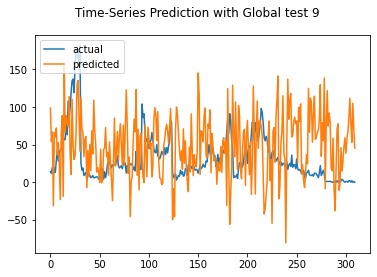

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 37.868
Test RMSE: 46.218
Test sMAPE: 96.627
Test R Squared: -1.153
{'mae': 37.86790706111539, 'rmse': 46.218164799343725, 'smape': 96.62716810244264, 'r2': -1.1530807996536447}


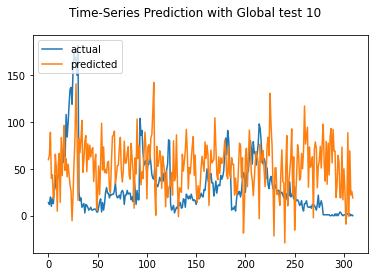

Test MAE: 36.580
Test RMSE: 42.591
Test sMAPE: 92.539
Test R Squared: -0.828
{'mae': 36.58018261694139, 'rmse': 42.5909005164295, 'smape': 92.5387819838815, 'r2': -0.8283889155600539}


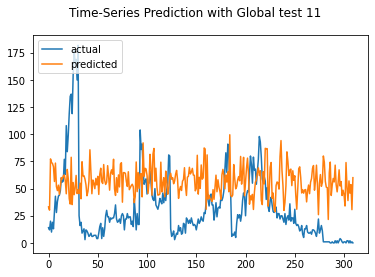

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 38.219
Test RMSE: 46.490
Test sMAPE: 94.897
Test R Squared: -1.179
{'mae': 38.21860883082113, 'rmse': 46.49037637405881, 'smape': 94.89655052032575, 'r2': -1.1785175290370868}


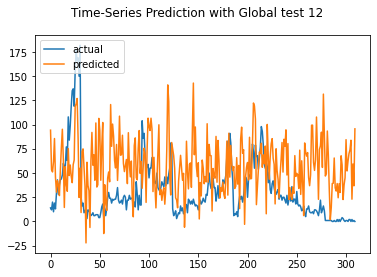

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 40.671
Test RMSE: 50.393
Test sMAPE: 104.108
Test R Squared: -1.560
{'mae': 40.67130555971976, 'rmse': 50.39299901400885, 'smape': 104.10770761223388, 'r2': -1.5596191142397315}


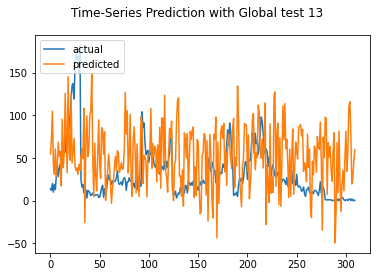

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 34.711
Test RMSE: 43.860
Test sMAPE: 110.503
Test R Squared: -0.939
{'mae': 34.71107556829529, 'rmse': 43.85987834717769, 'smape': 110.50326776454222, 'r2': -0.9389641527897878}


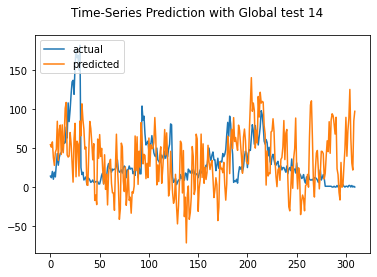

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 38.144
Test RMSE: 44.805
Test sMAPE: 93.890
Test R Squared: -1.023
{'mae': 38.143940450683715, 'rmse': 44.805203853596055, 'smape': 93.89046236720918, 'r2': -1.0234470758035292}


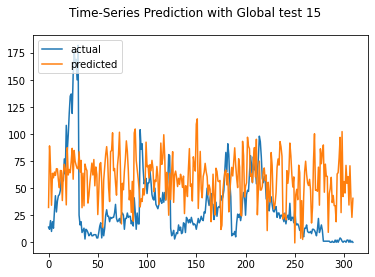

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 42.710
Test RMSE: 53.680
Test sMAPE: 106.612
Test R Squared: -1.904
{'mae': 42.70998909531101, 'rmse': 53.67959597511131, 'smape': 106.61158507009495, 'r2': -1.90437982502465}


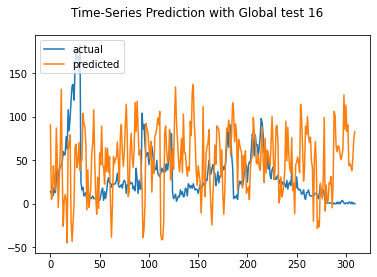

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 41.197
Test RMSE: 49.105
Test sMAPE: 98.285
Test R Squared: -1.430
{'mae': 41.19690101012107, 'rmse': 49.10460569458055, 'smape': 98.28477327357265, 'r2': -1.4304091445906542}


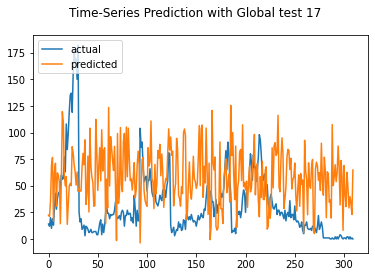

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 39.645
Test RMSE: 47.415
Test sMAPE: 95.693
Test R Squared: -1.266
{'mae': 39.6453837033241, 'rmse': 47.415301292066786, 'smape': 95.69266843105767, 'r2': -1.2660629157243766}


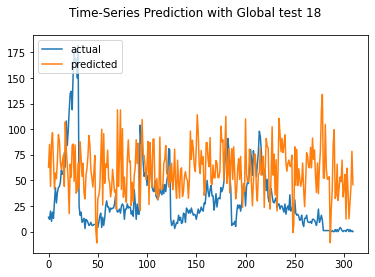

Test MAE: 45.047
Test RMSE: 50.342
Test sMAPE: 101.724
Test R Squared: -1.554
{'mae': 45.04739607803283, 'rmse': 50.342027072101764, 'smape': 101.72421009469402, 'r2': -1.5544436821154513}


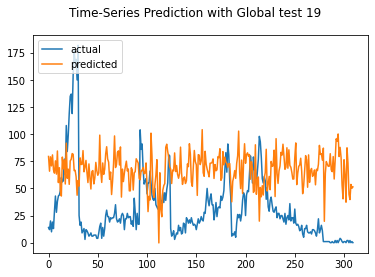

Test MAE: 41.271
Test RMSE: 45.881
Test sMAPE: 97.214
Test R Squared: -1.122
{'mae': 41.2705742497598, 'rmse': 45.88124333485863, 'smape': 97.21360827709607, 'r2': -1.1218041335699813}


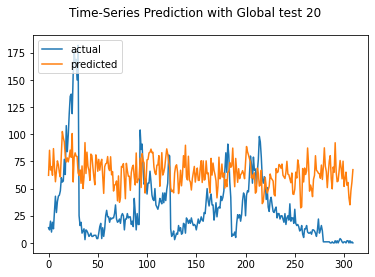

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 40.087
Test RMSE: 49.664
Test sMAPE: 102.129
Test R Squared: -1.486
{'mae': 40.086637167776786, 'rmse': 49.66388239084809, 'smape': 102.12917380959726, 'r2': -1.4860866878421346}


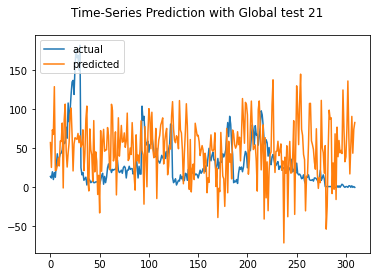

Test MAE: 42.340
Test RMSE: 52.506
Test sMAPE: 100.809
Test R Squared: -1.779
{'mae': 42.340022610079856, 'rmse': 52.50621884133139, 'smape': 100.80884768874759, 'r2': -1.778794452238615}


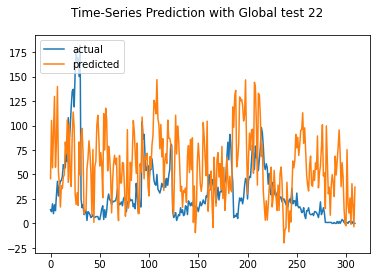

Test MAE: 42.979
Test RMSE: 50.153
Test sMAPE: 97.072
Test R Squared: -1.535
{'mae': 42.97909769858084, 'rmse': 50.15325804418262, 'smape': 97.07159955155505, 'r2': -1.5353226486956073}


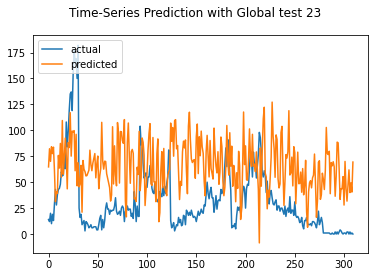

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 39.490
Test RMSE: 48.906
Test sMAPE: 98.562
Test R Squared: -1.411
{'mae': 39.49040980569778, 'rmse': 48.905679829557315, 'smape': 98.56245547413477, 'r2': -1.4107575478279224}


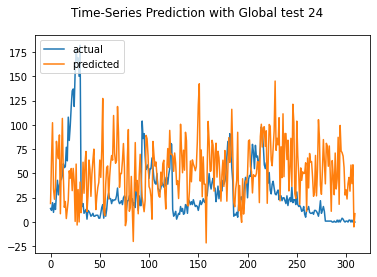

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 41.507
Test RMSE: 51.767
Test sMAPE: 101.774
Test R Squared: -1.701
{'mae': 41.507339688751, 'rmse': 51.76736427995101, 'smape': 101.77430535669846, 'r2': -1.7011396727796027}


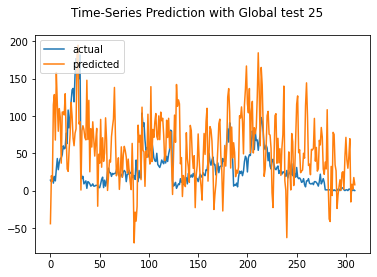

Test MAE: 39.216
Test RMSE: 44.595
Test sMAPE: 95.721
Test R Squared: -1.005
{'mae': 39.21617672212662, 'rmse': 44.59514507556222, 'smape': 95.72058335617822, 'r2': -1.004518628816013}


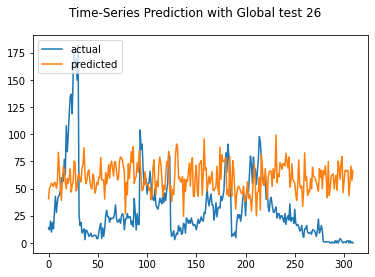

Test MAE: 43.511
Test RMSE: 49.641
Test sMAPE: 99.710
Test R Squared: -1.484
{'mae': 43.51066380162393, 'rmse': 49.64082924677327, 'smape': 99.70994256171073, 'r2': -1.4837792237384}


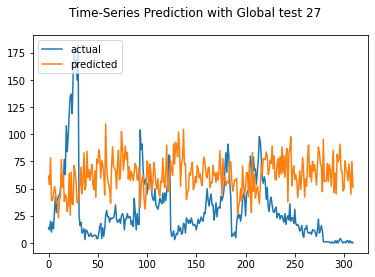

Test MAE: 34.226
Test RMSE: 41.156
Test sMAPE: 89.165
Test R Squared: -0.707
{'mae': 34.22632555807791, 'rmse': 41.15620354441676, 'smape': 89.16464093521975, 'r2': -0.707283123486508}


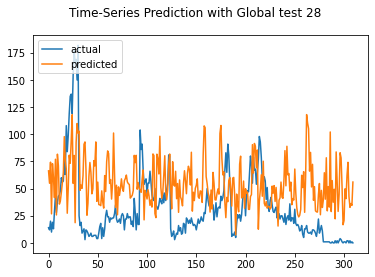

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 43.439
Test RMSE: 52.684
Test sMAPE: 96.112
Test R Squared: -1.798
{'mae': 43.43939797339901, 'rmse': 52.68427593232852, 'smape': 96.11218509837323, 'r2': -1.797673092293548}


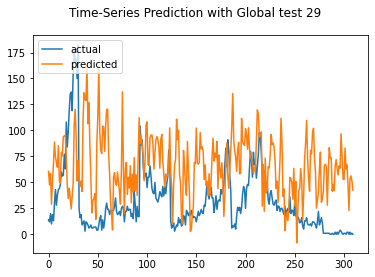

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 36.070
Test RMSE: 44.468
Test sMAPE: 90.558
Test R Squared: -0.993
{'mae': 36.0700797834704, 'rmse': 44.467651416200106, 'smape': 90.5584723311159, 'r2': -0.9930735220460138}


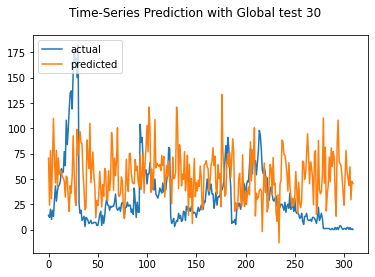

Test MAE: 40.461
Test RMSE: 48.168
Test sMAPE: 96.248
Test R Squared: -1.339
{'mae': 40.46104103211434, 'rmse': 48.16807096248352, 'smape': 96.24826115888281, 'r2': -1.3385865227447988}


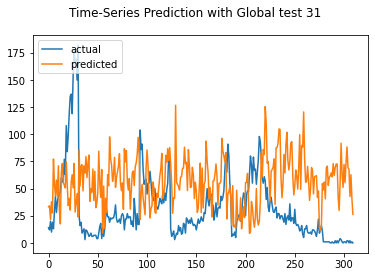

Test MAE: 43.109
Test RMSE: 51.328
Test sMAPE: 98.248
Test R Squared: -1.655
{'mae': 43.10861047160241, 'rmse': 51.32802662567697, 'smape': 98.24751430270177, 'r2': -1.6554863269943678}


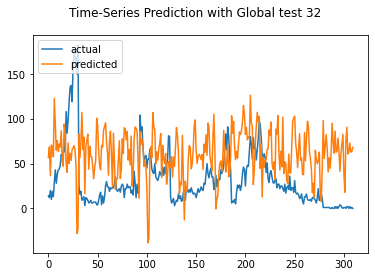

Test MAE: 41.990
Test RMSE: 47.172
Test sMAPE: 97.927
Test R Squared: -1.243
{'mae': 41.99012107541484, 'rmse': 47.1721148124682, 'smape': 97.92701131232444, 'r2': -1.2428778825240054}


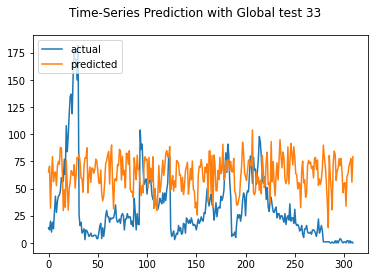

Test MAE: 67.025
Test RMSE: 100.998
Test sMAPE: 141.629
Test R Squared: -9.282
{'mae': 67.02459397681298, 'rmse': 100.99803787941977, 'smape': 141.62948238630554, 'r2': -9.28160246205221}


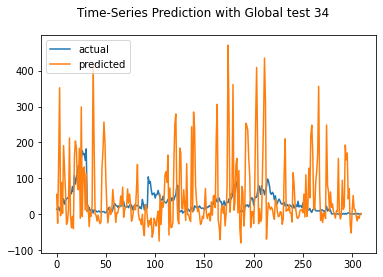

Test MAE: 41.019
Test RMSE: 46.980
Test sMAPE: 96.561
Test R Squared: -1.225
{'mae': 41.019033875003934, 'rmse': 46.9804420732183, 'smape': 96.56054900892585, 'r2': -1.2246881043602742}


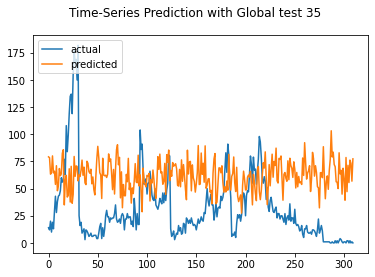

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 40.462
Test RMSE: 50.352
Test sMAPE: 102.127
Test R Squared: -1.556
{'mae': 40.461774564943006, 'rmse': 50.35249208322328, 'smape': 102.1270440648271, 'r2': -1.5555058189274602}


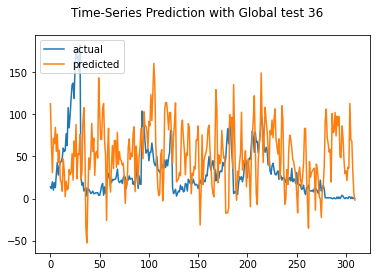

Test MAE: 34.588
Test RMSE: 43.835
Test sMAPE: 88.639
Test R Squared: -0.937
{'mae': 34.58750666187655, 'rmse': 43.83496729278303, 'smape': 88.63931857002694, 'r2': -0.9367622349377598}


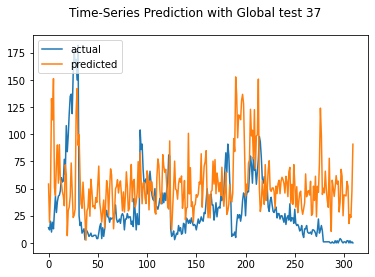

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 39.879
Test RMSE: 48.743
Test sMAPE: 97.775
Test R Squared: -1.395
{'mae': 39.87886234829503, 'rmse': 48.74282772460594, 'smape': 97.77478260299057, 'r2': -1.3947290094684424}


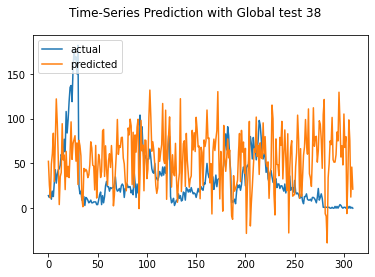

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 45.531
Test RMSE: 56.644
Test sMAPE: 107.763
Test R Squared: -2.234
{'mae': 45.53075179649937, 'rmse': 56.64395646229848, 'smape': 107.7629981033486, 'r2': -2.2340154853849694}


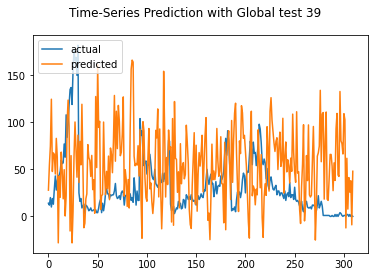

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 36.315
Test RMSE: 43.340
Test sMAPE: 93.795
Test R Squared: -0.893
{'mae': 36.315057277871716, 'rmse': 43.339884153459074, 'smape': 93.79526056191902, 'r2': -0.8932607295053172}


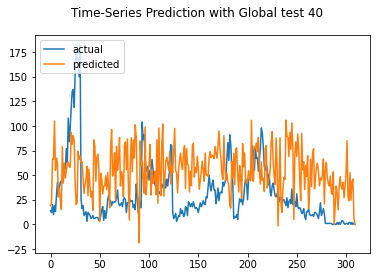

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 38.940
Test RMSE: 47.196
Test sMAPE: 96.007
Test R Squared: -1.245
{'mae': 38.93951763376113, 'rmse': 47.19628546810053, 'smape': 96.00676679052293, 'r2': -1.24517694068652}


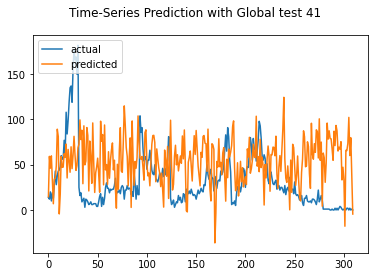

Test MAE: 35.304
Test RMSE: 41.196
Test sMAPE: 90.343
Test R Squared: -0.711
{'mae': 35.30419417350523, 'rmse': 41.195928618527645, 'smape': 90.34306526104017, 'r2': -0.7105805452382301}


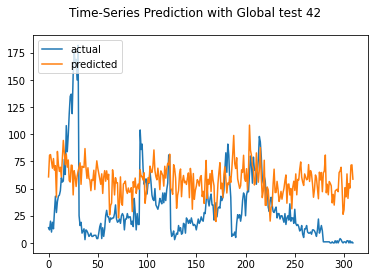

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 38.091
Test RMSE: 46.367
Test sMAPE: 96.291
Test R Squared: -1.167
{'mae': 38.091031149510414, 'rmse': 46.367273843967794, 'smape': 96.29115854204655, 'r2': -1.1669957483853057}


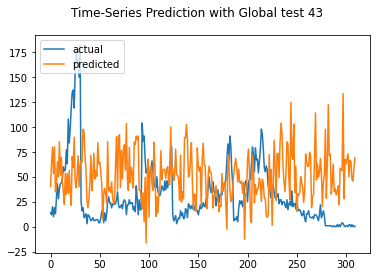

Test MAE: 48.587
Test RMSE: 55.901
Test sMAPE: 110.045
Test R Squared: -2.150
{'mae': 48.58708830341216, 'rmse': 55.90059727302253, 'smape': 110.04455951110074, 'r2': -2.149690139278309}


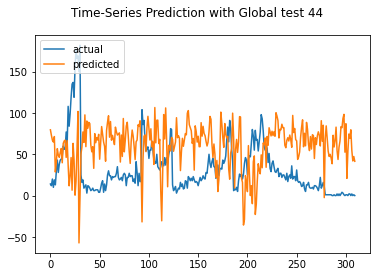

Test MAE: 39.397
Test RMSE: 45.092
Test sMAPE: 96.194
Test R Squared: -1.049
{'mae': 39.39704033636278, 'rmse': 45.09239673925409, 'smape': 96.1938827508128, 'r2': -1.049470036885456}


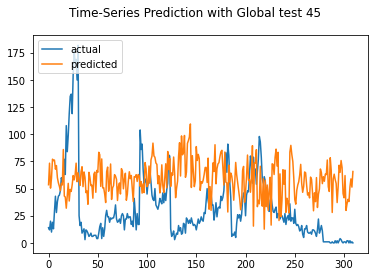

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 32.354
Test RMSE: 41.617
Test sMAPE: 100.184
Test R Squared: -0.746
{'mae': 32.35421876465121, 'rmse': 41.61745527040894, 'smape': 100.18428257629068, 'r2': -0.7457657841637697}


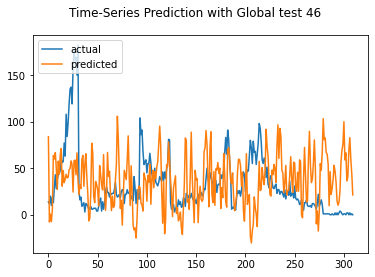

Test MAE: 40.849
Test RMSE: 49.567
Test sMAPE: 104.762
Test R Squared: -1.476
{'mae': 40.84853273005255, 'rmse': 49.56659176793853, 'smape': 104.76186776205292, 'r2': -1.4763558332027427}


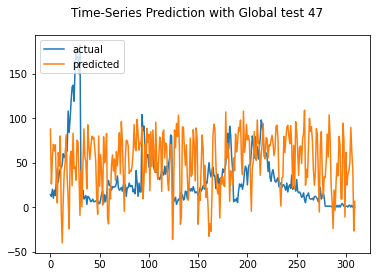

Test MAE: 36.292
Test RMSE: 42.223
Test sMAPE: 92.779
Test R Squared: -0.797
{'mae': 36.2919080242034, 'rmse': 42.22288070912473, 'smape': 92.77943627997462, 'r2': -0.7969279133133282}


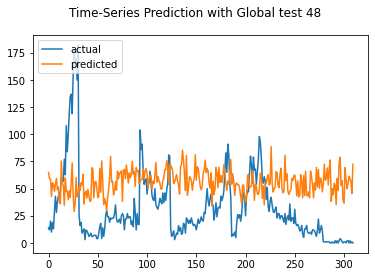

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 42.542
Test RMSE: 52.480
Test sMAPE: 104.597
Test R Squared: -1.776
{'mae': 42.54214571118355, 'rmse': 52.47958005223954, 'smape': 104.59737875760936, 'r2': -1.7759755502807604}


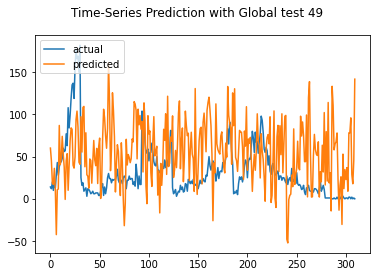

Test MAE: 42.568
Test RMSE: 48.702
Test sMAPE: 98.107
Test R Squared: -1.391
{'mae': 42.5679179222353, 'rmse': 48.70167958159059, 'smape': 98.10689965325007, 'r2': -1.3906875098773916}


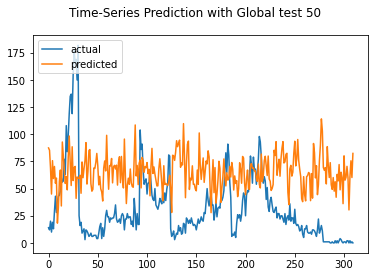

Test MAE: 37.711
Test RMSE: 43.950
Test sMAPE: 92.832
Test R Squared: -0.947
{'mae': 37.711438406667405, 'rmse': 43.950218196086006, 'smape': 92.83232785613711, 'r2': -0.9469598943624875}


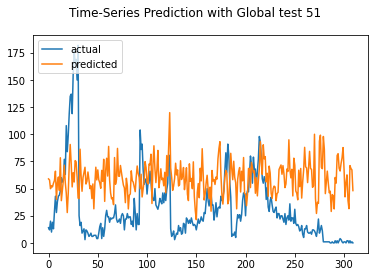

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 40.506
Test RMSE: 47.103
Test sMAPE: 95.589
Test R Squared: -1.236
{'mae': 40.50580407111875, 'rmse': 47.1031102290093, 'smape': 95.58857207401903, 'r2': -1.2363208029986819}


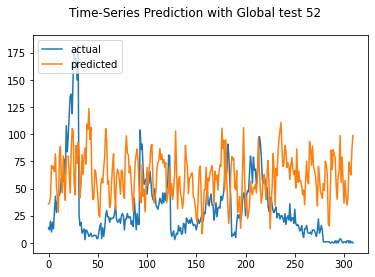

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 34.560
Test RMSE: 42.771
Test sMAPE: 96.101
Test R Squared: -0.844
{'mae': 34.55988845248376, 'rmse': 42.77137746508237, 'smape': 96.10064691866727, 'r2': -0.843917171134702}


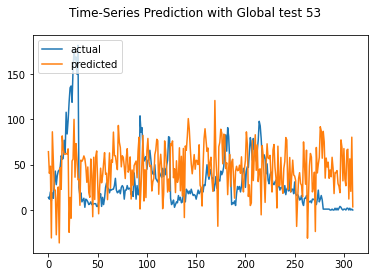

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 42.043
Test RMSE: 52.137
Test sMAPE: 106.328
Test R Squared: -1.740
{'mae': 42.04281507038301, 'rmse': 52.1373339456835, 'smape': 106.32772417985846, 'r2': -1.739886508109119}


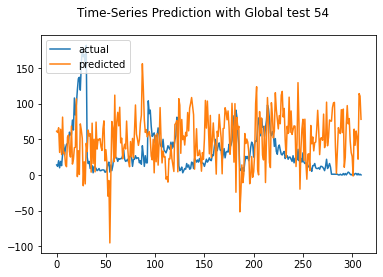

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 29.512
Test RMSE: 38.304
Test sMAPE: 92.209
Test R Squared: -0.479
{'mae': 29.511746619978258, 'rmse': 38.30406970623524, 'smape': 92.20874133976446, 'r2': -0.47885220295881537}


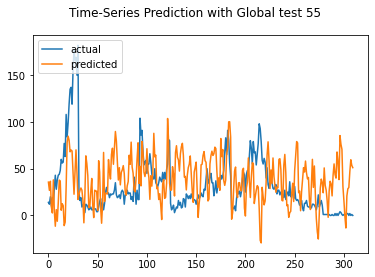

Test MAE: 41.297
Test RMSE: 48.786
Test sMAPE: 96.307
Test R Squared: -1.399
{'mae': 41.29680367439024, 'rmse': 48.78587832330635, 'smape': 96.307142829088, 'r2': -1.3989610185628476}


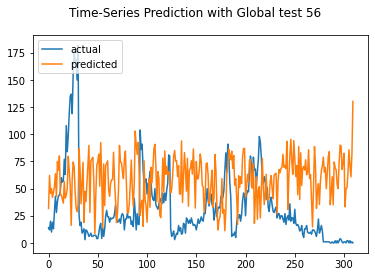

Test MAE: 40.006
Test RMSE: 44.896
Test sMAPE: 96.731
Test R Squared: -1.032
{'mae': 40.00582039125504, 'rmse': 44.89576447274656, 'smape': 96.73058783085425, 'r2': -1.0316349554218416}


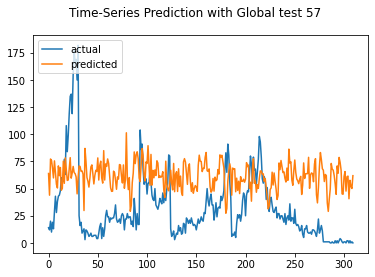

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 39.016
Test RMSE: 47.231
Test sMAPE: 94.143
Test R Squared: -1.248
{'mae': 39.01553973949725, 'rmse': 47.23092175802149, 'smape': 94.14318174681621, 'r2': -1.2484735193690635}


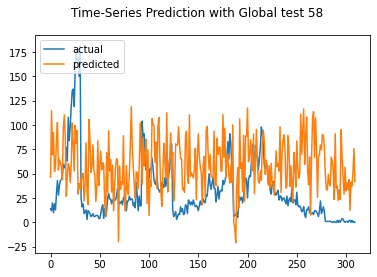

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 31.232
Test RMSE: 39.948
Test sMAPE: 90.951
Test R Squared: -0.608
{'mae': 31.232465367836344, 'rmse': 39.947627071016605, 'smape': 90.95107733752025, 'r2': -0.6084846038747047}


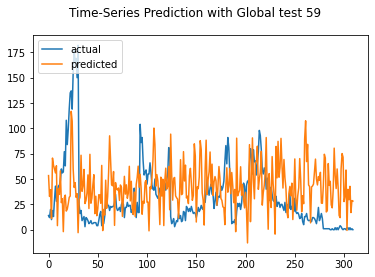

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 39.510
Test RMSE: 53.474
Test sMAPE: 111.734
Test R Squared: -1.882
{'mae': 39.51040067941912, 'rmse': 53.473526139473385, 'smape': 111.73435827444445, 'r2': -1.8821234623965157}


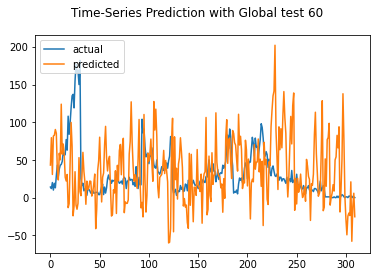

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 35.170
Test RMSE: 45.108
Test sMAPE: 108.843
Test R Squared: -1.051
{'mae': 35.170262593800025, 'rmse': 45.10820129883812, 'smape': 108.84341424894629, 'r2': -1.0509069375630489}


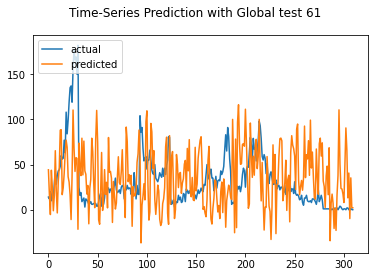

Test MAE: 39.083
Test RMSE: 45.835
Test sMAPE: 94.868
Test R Squared: -1.118
{'mae': 39.0832469201857, 'rmse': 45.83540445160929, 'smape': 94.8682119465723, 'r2': -1.1175665611232355}


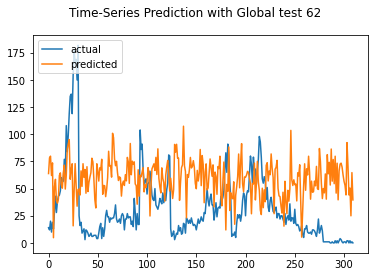

Test MAE: 46.262
Test RMSE: 54.338
Test sMAPE: 102.886
Test R Squared: -1.976
{'mae': 46.26154312318371, 'rmse': 54.337503146610764, 'smape': 102.88579757113186, 'r2': -1.9760093489560964}


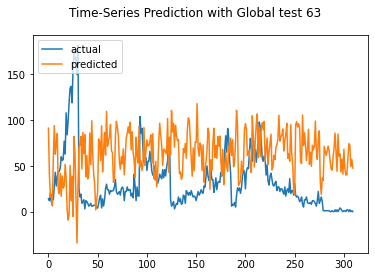

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 41.096
Test RMSE: 50.487
Test sMAPE: 98.591
Test R Squared: -1.569
{'mae': 41.095839237205446, 'rmse': 50.48687081831697, 'smape': 98.59120020063722, 'r2': -1.5691640852386248}


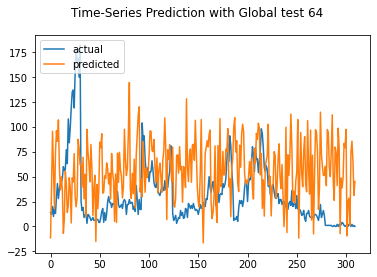

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 40.002
Test RMSE: 48.152
Test sMAPE: 103.539
Test R Squared: -1.337
{'mae': 40.001543386905425, 'rmse': 48.152353180492305, 'smape': 103.53874162600926, 'r2': -1.3370605577134898}


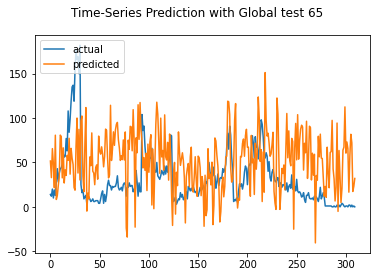

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 34.745
Test RMSE: 41.581
Test sMAPE: 102.552
Test R Squared: -0.743
{'mae': 34.74478252972326, 'rmse': 41.58138187016475, 'smape': 102.55218385400386, 'r2': -0.7427406873986997}


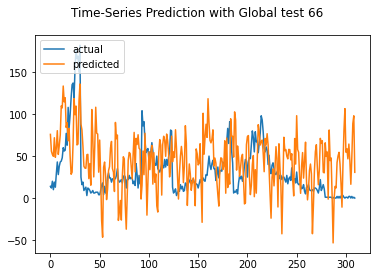

Test MAE: 43.084
Test RMSE: 48.006
Test sMAPE: 99.578
Test R Squared: -1.323
{'mae': 43.084321668071134, 'rmse': 48.006469577654734, 'smape': 99.57777745170947, 'r2': -1.3229211716506861}


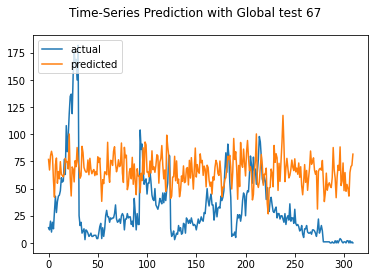

Test MAE: 36.917
Test RMSE: 43.001
Test sMAPE: 92.756
Test R Squared: -0.864
{'mae': 36.91712781536964, 'rmse': 43.00081368066031, 'smape': 92.75616727703873, 'r2': -0.8637526828951541}


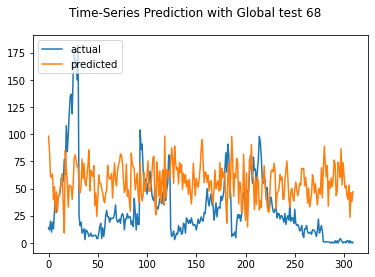

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 38.817
Test RMSE: 47.973
Test sMAPE: 102.571
Test R Squared: -1.320
{'mae': 38.817309964664524, 'rmse': 47.97291061579703, 'smape': 102.57105567104131, 'r2': -1.3196746269040283}


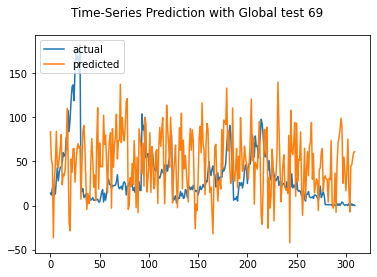

Test MAE: 44.463
Test RMSE: 58.581
Test sMAPE: 101.670
Test R Squared: -2.459
{'mae': 44.46284954057587, 'rmse': 58.581409818087735, 'smape': 101.669643620749, 'r2': -2.4590319451194818}


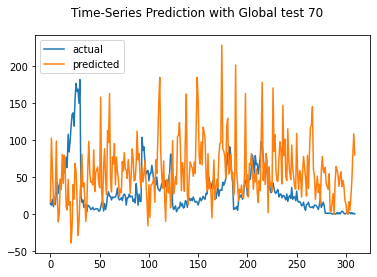

Test MAE: 52.502
Test RMSE: 60.045
Test sMAPE: 104.375
Test R Squared: -2.634
{'mae': 52.502166197376866, 'rmse': 60.04527104430101, 'smape': 104.37489722789743, 'r2': -2.6340638508096625}


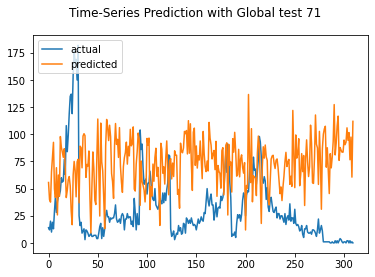

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 41.523
Test RMSE: 51.600
Test sMAPE: 97.151
Test R Squared: -1.684
{'mae': 41.522662613372646, 'rmse': 51.599729469436234, 'smape': 97.15077670237477, 'r2': -1.6836741556801735}


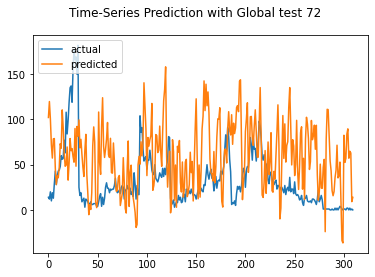

Test MAE: 40.652
Test RMSE: 48.509
Test sMAPE: 97.256
Test R Squared: -1.372
{'mae': 40.651759945961736, 'rmse': 48.50857306738454, 'smape': 97.25596156253006, 'r2': -1.3717665166283997}


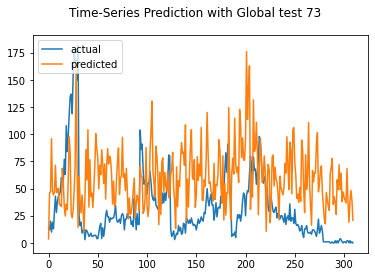

Test MAE: 34.671
Test RMSE: 40.918
Test sMAPE: 89.853
Test R Squared: -0.688
{'mae': 34.670577609154485, 'rmse': 40.918075094576274, 'smape': 89.85254136624104, 'r2': -0.6875837101078672}


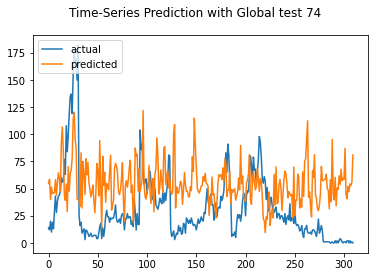

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 44.484
Test RMSE: 53.451
Test sMAPE: 113.950
Test R Squared: -1.880
{'mae': 44.48363715977438, 'rmse': 53.45085991503195, 'smape': 113.949572225046, 'r2': -1.8796806456724466}


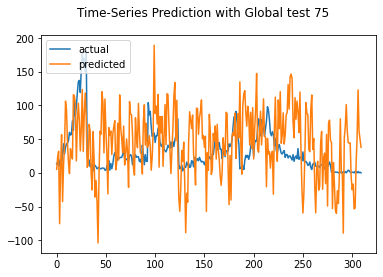

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 41.609
Test RMSE: 52.605
Test sMAPE: 109.750
Test R Squared: -1.789
{'mae': 41.60927433390771, 'rmse': 52.60489876945353, 'smape': 109.75019597555759, 'r2': -1.789249172402867}


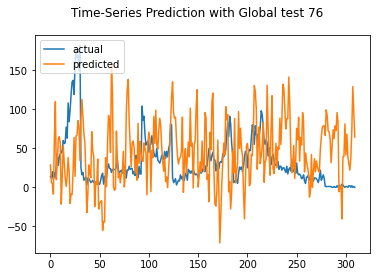

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 37.524
Test RMSE: 45.380
Test sMAPE: 102.243
Test R Squared: -1.076
{'mae': 37.52363751982489, 'rmse': 45.380287638361935, 'smape': 102.24289734950442, 'r2': -1.0757231220144674}


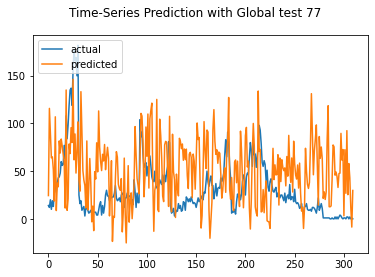

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 35.244
Test RMSE: 46.303
Test sMAPE: 128.194
Test R Squared: -1.161
{'mae': 35.24399564343114, 'rmse': 46.303162602293106, 'smape': 128.19357115874968, 'r2': -1.161007354874719}


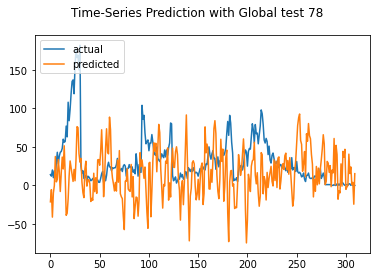

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 44.985
Test RMSE: 52.647
Test sMAPE: 102.844
Test R Squared: -1.794
{'mae': 44.984517296668024, 'rmse': 52.64651866624776, 'smape': 102.84354155143669, 'r2': -1.7936645097083042}


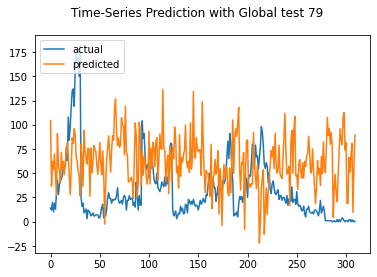

Test MAE: 36.664
Test RMSE: 43.619
Test sMAPE: 91.386
Test R Squared: -0.918
{'mae': 36.66401662365083, 'rmse': 43.61877725739902, 'smape': 91.38607221846765, 'r2': -0.917705477035675}


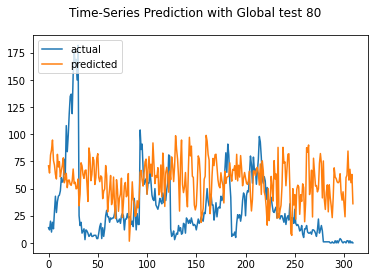

Test MAE: 42.651
Test RMSE: 50.727
Test sMAPE: 99.070
Test R Squared: -1.594
{'mae': 42.6509161554998, 'rmse': 50.727059549610395, 'smape': 99.07009755952411, 'r2': -1.593667570032053}


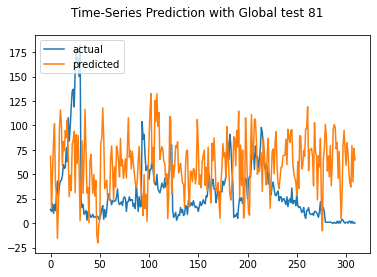

Test MAE: 38.092
Test RMSE: 44.655
Test sMAPE: 94.885
Test R Squared: -1.010
{'mae': 38.09165449142456, 'rmse': 44.654729834130464, 'smape': 94.8851061853556, 'r2': -1.009878788581874}


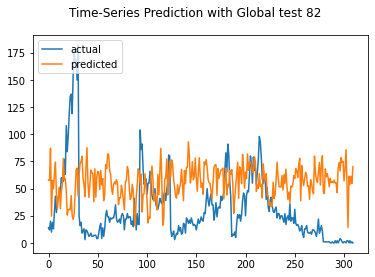

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 42.107
Test RMSE: 50.627
Test sMAPE: 96.572
Test R Squared: -1.583
{'mae': 42.10723501597681, 'rmse': 50.6271275373534, 'smape': 96.57203355881947, 'r2': -1.5834586156834782}


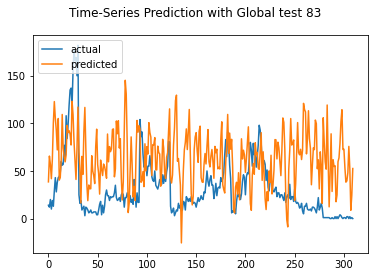

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 40.718
Test RMSE: 50.771
Test sMAPE: 107.780
Test R Squared: -1.598
{'mae': 40.71758238000255, 'rmse': 50.77070347191524, 'smape': 107.78027132735318, 'r2': -1.5981325054251836}


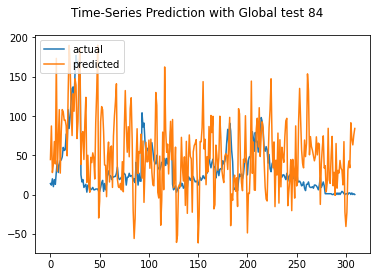

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 35.438
Test RMSE: 43.080
Test sMAPE: 91.485
Test R Squared: -0.871
{'mae': 35.438057599529145, 'rmse': 43.08014585569277, 'smape': 91.4853365937472, 'r2': -0.8706358988485363}


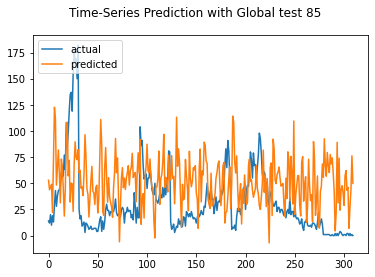

Test MAE: 35.453
Test RMSE: 42.335
Test sMAPE: 89.856
Test R Squared: -0.807
{'mae': 35.45328730613955, 'rmse': 42.33541555574247, 'smape': 89.85600109756807, 'r2': -0.8065192289174599}


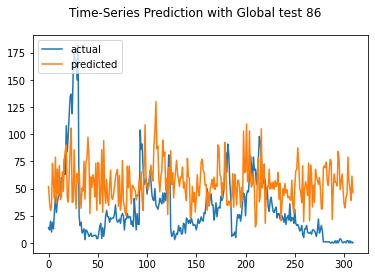

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 40.354
Test RMSE: 49.421
Test sMAPE: 99.136
Test R Squared: -1.462
{'mae': 40.354172263606905, 'rmse': 49.42124956201313, 'smape': 99.13577020036465, 'r2': -1.4618544798393809}


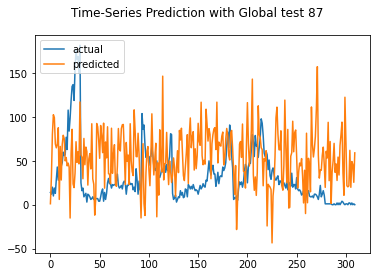

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 41.025
Test RMSE: 49.608
Test sMAPE: 101.760
Test R Squared: -1.480
{'mae': 41.02481644461232, 'rmse': 49.60769412787279, 'smape': 101.76048684126025, 'r2': -1.4804644986006728}


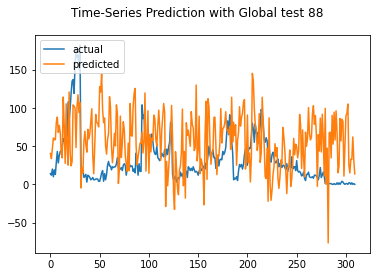

Test MAE: 43.523
Test RMSE: 52.183
Test sMAPE: 103.130
Test R Squared: -1.745
{'mae': 43.52310919752044, 'rmse': 52.18338073842812, 'smape': 103.13008841634984, 'r2': -1.7447282861255866}


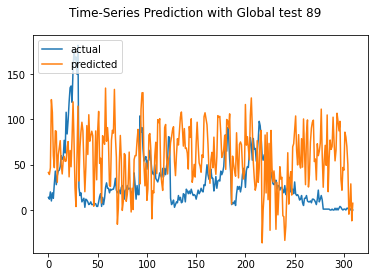

Test MAE: 42.437
Test RMSE: 47.261
Test sMAPE: 98.568
Test R Squared: -1.251
{'mae': 42.43700292648808, 'rmse': 47.26097364706377, 'smape': 98.56811699537532, 'r2': -1.2513357278992814}


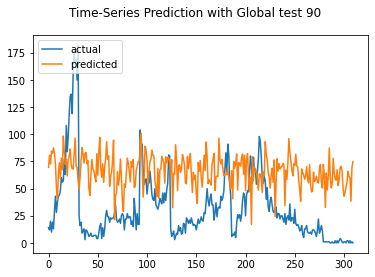

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 41.542
Test RMSE: 47.865
Test sMAPE: 98.735
Test R Squared: -1.309
{'mae': 41.54174034057125, 'rmse': 47.865207763458265, 'smape': 98.73463609661614, 'r2': -1.3092706251193036}


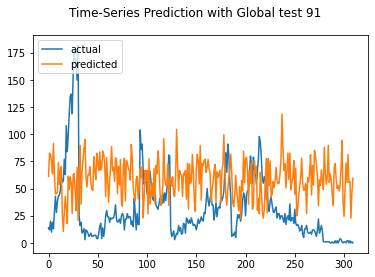

Test MAE: 34.865
Test RMSE: 41.938
Test sMAPE: 90.738
Test R Squared: -0.773
{'mae': 34.86530492536484, 'rmse': 41.93833235132593, 'smape': 90.737540459091, 'r2': -0.7727898176250243}


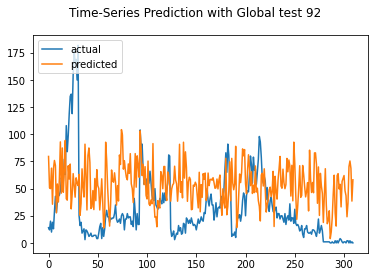

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 37.327
Test RMSE: 47.786
Test sMAPE: 97.733
Test R Squared: -1.302
{'mae': 37.327135342744086, 'rmse': 47.786115214009854, 'smape': 97.73331999456163, 'r2': -1.3016452451294271}


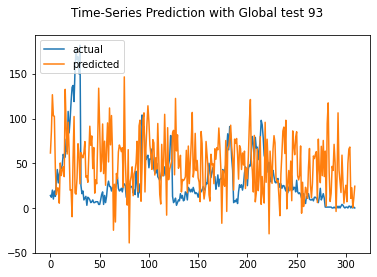

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 35.557
Test RMSE: 45.516
Test sMAPE: 120.466
Test R Squared: -1.088
{'mae': 35.55705969852786, 'rmse': 45.51643221474267, 'smape': 120.46646650141047, 'r2': -1.0881964829863486}


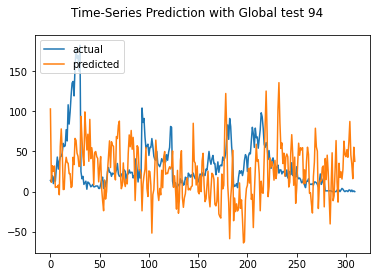

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 34.845
Test RMSE: 43.167
Test sMAPE: 96.422
Test R Squared: -0.878
{'mae': 34.84501917429509, 'rmse': 43.16712145688663, 'smape': 96.42167630702883, 'r2': -0.878196872375592}


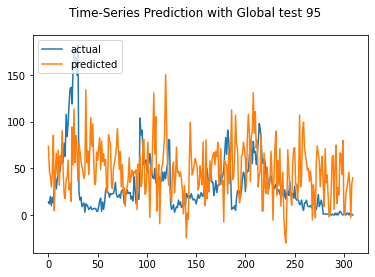

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 30.501
Test RMSE: 40.122
Test sMAPE: 93.603
Test R Squared: -0.623
{'mae': 30.500529068516148, 'rmse': 40.121965558941135, 'smape': 93.60301923009712, 'r2': -0.6225546599528422}


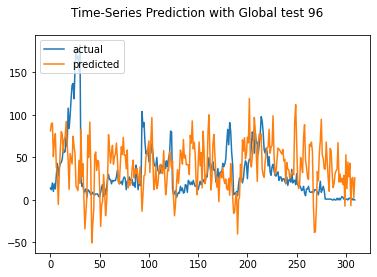

Test MAE: 41.422
Test RMSE: 47.536
Test sMAPE: 98.806
Test R Squared: -1.278
{'mae': 41.42156448691122, 'rmse': 47.535578747123665, 'smape': 98.80586191446555, 'r2': -1.2775740510382092}


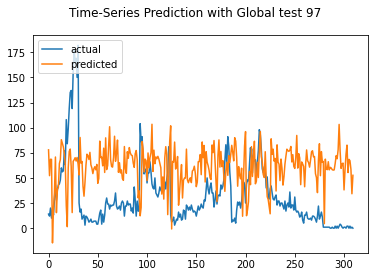

Test MAE: 36.968
Test RMSE: 44.275
Test sMAPE: 91.561
Test R Squared: -0.976
{'mae': 36.96750413217852, 'rmse': 44.274604860060535, 'smape': 91.56136436947718, 'r2': -0.9758061017759572}


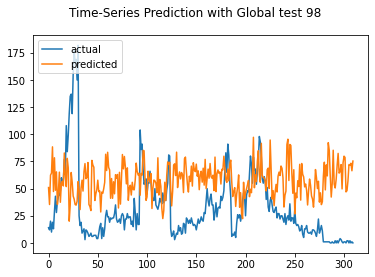

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 40.132
Test RMSE: 50.835
Test sMAPE: 125.432
Test R Squared: -1.605
{'mae': 40.13200617480663, 'rmse': 50.83535482897306, 'smape': 125.43193849359992, 'r2': -1.6047536364704813}


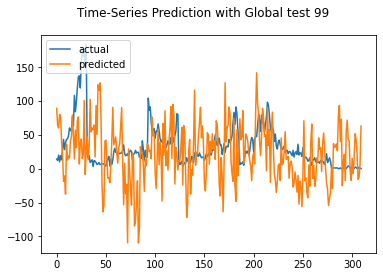

rmse : average=48.217, std=6.794
mae : average=39.721, std=4.679
smape : average=100.566, std=9.209
r2 : average=-1.390, std=0.894


([48.21650439999873, 6.793782948296292],
 [39.721190712915316, 4.679075865610688],
 [100.56644628098938, 9.209376165885526],
 [-1.3898138161246556, 0.894396031345089])

In [13]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')